# 赛事背景

随着企业持续产生的商品销量，其数据对于自身营销规划、市场分析、物流规划都有重要意义。但是销量预测的影响因素繁多，传统的基于统计的计量模型，比如时间序列模型等由于对现实的假设情况过多，导致预测结果较差。因此需要更加优秀的智能AI算法，以提高预测的准确性，从而助力企业降低库存成本、缩短交货周期、提高企业抗风险能力。

# 赛事任务

本次大赛提供了商品销量历史数据作为训练样本，参赛选手需基于提供的样本构建模型，预测商品未来三个月的销售量。

# 评审规则

1.数据说明

本次比赛为参赛选手提供了2类数据：商品历史销量数据和商品月订单数据。商品历史需求销量数据提供了商品编码、日期、是否促销、商品销售量。商品月订单数据提供了商品编码、商品类型、月份、订单数量、商品月初和月末库存量。（label空值的含义表示该商品当天无销量）

- 初赛提供了2018年2月1日至2020年12月31日的若干商品历史销量数据和订单数据，预测其2021年1月至3月的销量数据。

- 决赛提供了2018年2月1日至2021年3月31日的若干商品历史销量数据和订单数据，预测其2021年4月至6月的销量数据。

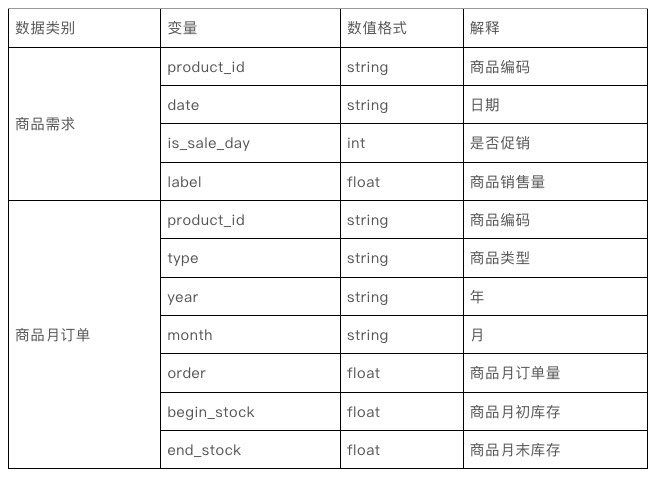

2.评估指标

本模型依据提交的结果文件，采用评价指标为准确率。

（1）计算每个月商品预测准确率

（2）计算累计所有预测月份的商品平均准确率



# 读取数据

In [64]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from matplotlib.pyplot import plot, show


LABEL = 'label'

df_train = pd.read_csv('data/商品需求训练集.csv')
df_train_order = pd.read_csv('data/商品月订单训练集.csv')
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train = df_train.groupby(['product_id', 'year', 'month'])[['is_sale_day', 'label']].sum().reset_index()
df_train = df_train.merge(df_train_order, on=['product_id', 'year', 'month'], how='left')

df_test = pd.read_csv('data/商品需求测试集.csv')
df_test_order = pd.read_csv('data/商品月订单测试集.csv')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test = df_test.groupby(['product_id', 'year', 'month'])[['is_sale_day']].sum().reset_index()
df_test = df_test.merge(df_test_order, on=['product_id', 'year', 'month'], how='left')

# 特征工程

In [65]:
# feats = ['month', 'order', 'start_stock', 'end_stock']

df = pd.concat([df_train, df_test])

for i in range(1, 8):
    for f in [LABEL, 'order', 'start_stock', 'end_stock']:
        df[f+'_shift_%d'%i] = df.groupby('product_id')[f].shift(i+3)

for i in range(4):
    for f in ['order', 'start_stock', 'end_stock']:
        df[f+'_shift_-%d'%i] = df.groupby('product_id')[f].shift(-i)

for i in [3, 6]:
    for f in [LABEL, 'order', 'start_stock', 'end_stock']:
        df[f+'_mean_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].mean(axis=1)
        df[f+'_std_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].std(axis=1)
        df[f+'_median_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].median(axis=1)

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['type'] = df['type'].astype('category')

df['product_id'] = df['product_id'].astype('category')

df_train = df[df[LABEL].notna()].reset_index(drop=True)
df_test = df[df[LABEL].isna()].reset_index(drop=True)

feats = [f for f in df_test if f not in ['year', 'label']]

df_train[LABEL+'_log1p'] = np.log1p(df_train[LABEL])

# 模型训练

In [78]:
params = {
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'verbose': -1,
    'seed': 2222,
    'n_jobs': -1,
}

fold_num = 5
seeds = [2222]
oof = np.zeros(len(df_train))
importance = 0
pred_y = pd.DataFrame()
for seed in seeds:
    kf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_train[feats], df_train['product_id'])):
        print('-----------', fold)
        train = lgb.Dataset(df_train.loc[train_idx, feats],
                            df_train.loc[train_idx, LABEL+'_log1p'])
        val = lgb.Dataset(df_train.loc[val_idx, feats],
                          df_train.loc[val_idx, LABEL+'_log1p'])
        model = lgb.train(params, train, valid_sets=[val], num_boost_round=10000,
                          callbacks=[lgb.early_stopping(100), lgb.log_evaluation(1000)])

        oof[val_idx] += model.predict(df_train.loc[val_idx, feats]) / len(seeds)
        pred_y['fold_%d_seed_%d' % (fold, seed)] = model.predict(df_test[feats])
        importance += model.feature_importance(importance_type='gain') / fold_num

df_train['target_weight'] = df_train[LABEL] / df_train.groupby(['year', 'month'])[LABEL].transform('sum')
df_train['oof'] = np.expm1(oof)
score1 = np.sum((1 - np.abs(df_train[LABEL]-df_train['oof']) / (df_train[LABEL])
                 ) *
                df_train['target_weight']) / 35
print(score1)
print(np.mean(np.abs(df_train[LABEL]-np.expm1(oof))/(df_train[LABEL]+1)))
plot(df_train[LABEL])
plot(np.expm1(oof))
show()


feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
print(feats_importance.sort_values('importance', ascending=False)[:30])
df_test[LABEL] = np.expm1(pred_y.mean(axis=1).values)

df_test = df_test.sort_values(by=['month', 'product_id'])
sub = pd.read_csv('data/提交示例.csv')
sub[LABEL] = df_test[LABEL].values
sub[LABEL] = sub[LABEL].map(lambda x: x if x >= 0 else 0)

sub.to_csv('ans/baseline0613.csv', index=False)